In [ ]:
import pandas as pd
import numpy as np
import pickle5
import random, os
from tqdm.notebook import tqdm
import torch
import transformers
pd.__version__

'1.3.5'

In [ ]:
def seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed(12345)

In [ ]:
with open('data_cleaned.pickle', 'rb') as handle:
    data = pickle5.load(handle)

In [ ]:
data.drop(data[data['url_cleaned'].isna()].index, inplace=True)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_transformed = mlb.fit_transform(data['target_cleaned'].values)

In [ ]:
# Getting a sense of how the tags data looks like
print(len(y_transformed[1]))
print(mlb.inverse_transform(np.array(y_transformed[1]).reshape(1,-1)))

267
[('529', '582', '978')]


In [ ]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(data['url_cleaned'], y_transformed, test_size=0.1, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234)

In [ ]:
# !pip install transformers

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__


'1.11.0+cu113'

In [ ]:
MAX_LEN = 40
bs = 32
lr = 2e-5
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-uncased'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(list(X_train.values), truncation=True, add_special_tokens=True, max_length=MAX_LEN, return_token_type_ids=False, padding='max_length', return_attention_mask=True, return_tensors='pt')
val_encodings = tokenizer(list(X_val.values), truncation=True, add_special_tokens=True, max_length=MAX_LEN, return_token_type_ids=False, padding='max_length', return_attention_mask=True, return_tensors='pt')
test_encodings = tokenizer(list(X_test.values), truncation=True, add_special_tokens=True, max_length=MAX_LEN, return_token_type_ids=False, padding='max_length', return_attention_mask=True, return_tensors='pt')

In [ ]:
token_counts = []
for _, row in data.iterrows():
  token_count = len(tokenizer.encode(
    row["url_cleaned"],
    # max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)

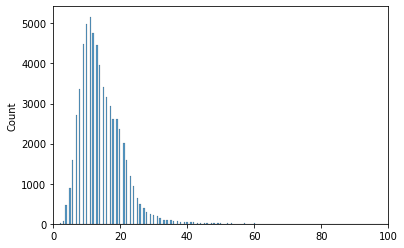

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(token_counts)
plt.xlim([0, 100]);

In [ ]:
import torch

class URLDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = URLDataset(train_encodings, y_train)
val_dataset = URLDataset(val_encodings, y_val)
test_dataset = URLDataset(test_encodings, y_test)

In [ ]:
print(data_point['input_ids'].shape)
print(data_point['attention_mask'].shape)
print(data_point['labels'])

torch.Size([40])
torch.Size([40])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])


In [ ]:
# mlb.classes_

In [ ]:
class_names = mlb.classes_

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=True)

In [ ]:
from transformers import BertModel, AdamW
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class BertCustomModel(torch.nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertCustomModel, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        # self.dropout = nn.Dropout(do_prob) ## optional
        ## 768 = self.bert.hidden_size
        self.classifier = torch.nn.Linear(768, len(class_names))

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
  
    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(input_ids, attention_mask)["pooler_output"] ### model outputs two hidden_state and pooled_output
        # out1 = self.dropout(pooled_output)
        output = self.classifier(pooled_output)
        return output
    

model = BertCustomModel()
model.to(device);

Downloading:   0%|          | 0.00/641M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device

device(type='cuda')

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=lr)

In [ ]:
EPOCHS = 5

In [ ]:
from tqdm.notebook import trange
from sklearn import metrics

In [ ]:
MODEL_PATH = 'drive/MyDrive/url_prediction/model.h5'

In [ ]:
# !pip install transformers[onnx]

In [ ]:
training_scores = []
best_auc = 0
## for each epoch
for epoch in trange(EPOCHS, desc="Epoch"):

    train_loss = 0
    valid_loss = 0

    model.train()
    print('#### Training epoch {}   ####'.format(epoch))
 
    ## for each bach 
    for batch in tqdm(train_loader, leave=False, desc="Batch"):

        ## getting model inputs
        input_ids = batch['input_ids'].to(device, dtype = torch.long)
        attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.float)

        outputs = model(input_ids, attention_mask=attention_mask)

        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if _%500 == 0:
        #     print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        train_loss += loss.item()

    train_loss=train_loss/len(train_loader)

    print('#### Validating epoch {}   ####'.format(epoch))

    eval_loss = 0.0
    model.eval()

    eval_labels = []
    eval_outputs = []

    with torch.no_grad():
      for batch_idx, batch_val in enumerate(val_loader, 0):

            ids = batch_val['input_ids'].to(device, dtype = torch.long)
            mask = batch_val['attention_mask'].to(device, dtype = torch.long)
            # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            labels = batch_val['labels'].to(device, dtype = torch.float)

            outputs = model(ids, mask)

            loss = loss_fn(outputs, labels)
            eval_loss += loss.item()

            eval_labels.extend(labels.cpu().detach().numpy().tolist())
            eval_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())


    eval_outputs = np.array(eval_outputs) >= 0.5
    auc = metrics.roc_auc_score(eval_labels, eval_outputs)
    # print(f"AUC Score = {auc}")
    if auc > best_auc:
        torch.save(model.state_dict(), MODEL_PATH)
        # model.save_pretrained(MODEL_PATH)
        # tokenizer.save_pretrained(MODEL_PATH)
        best_auc = auc


    avg_train_loss, avg_val_loss = train_loss / len(train_loader), eval_loss / len(val_loader)

    scores =  {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. AUC.': auc
        }
    training_scores.append(scores)
    print(scores)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

#### Training epoch 0   ####


Batch:   0%|          | 0/1423 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


#### Validating epoch 0   ####
{'epoch': 1, 'Training Loss': 7.125879100518845e-05, 'Valid. Loss': 0.06413972019898088, 'Valid. AUC.': 0.5}
#### Training epoch 1   ####


Batch:   0%|          | 0/1423 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


#### Validating epoch 1   ####
{'epoch': 2, 'Training Loss': 3.934958125047079e-05, 'Valid. Loss': 0.046835006465821456, 'Valid. AUC.': 0.5173933952670265}
#### Training epoch 2   ####


Batch:   0%|          | 0/1423 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


#### Validating epoch 2   ####
{'epoch': 3, 'Training Loss': 2.873294538338985e-05, 'Valid. Loss': 0.03709567705525106, 'Valid. AUC.': 0.5493641883344388}
#### Training epoch 3   ####


Batch:   0%|          | 0/1423 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


#### Validating epoch 3   ####
{'epoch': 4, 'Training Loss': 2.3745772599839154e-05, 'Valid. Loss': 0.03272026071450516, 'Valid. AUC.': 0.5861398006852954}
#### Training epoch 4   ####


Batch:   0%|          | 0/1423 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


#### Validating epoch 4   ####
{'epoch': 5, 'Training Loss': 2.11237189232818e-05, 'Valid. Loss': 0.030402460501769955, 'Valid. AUC.': 0.6170961774638947}
